<a href="https://colab.research.google.com/gist/snsamarasekara/b435af2b3e416c40dd7920807bdb30f6/copy-of-final-chest-xray-original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importing Data

In [ ]:
! pip install -q kaggle #importing Dataset
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

100% 1.14G/1.14G [00:33<00:00, 36.1MB/s]
100% 1.14G/1.14G [00:33<00:00, 36.6MB/s]


In [ ]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
#Define Directories for train, test & Validation Set
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500 img_height = 500
img_width = 500
 

2. Data preprocessing:
Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)


In [ ]:
img_height = 500
img_width = 500

train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


<function matplotlib.pyplot.show>

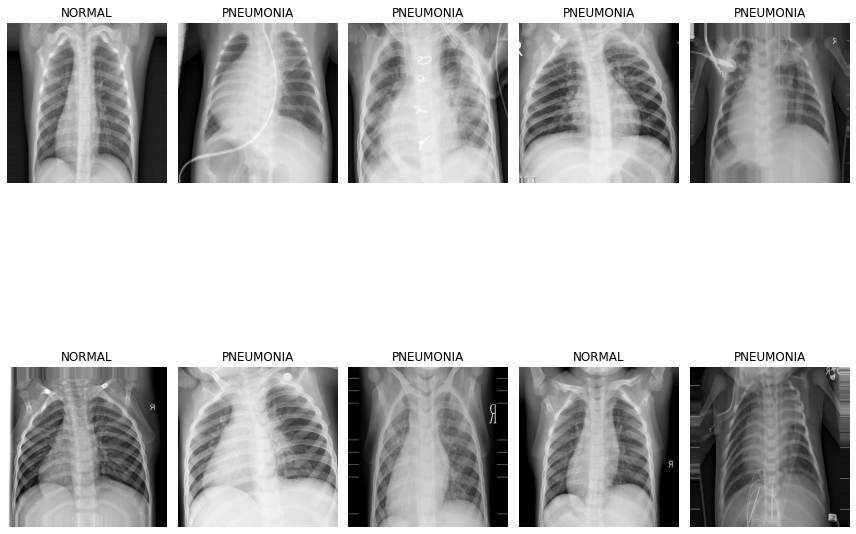

In [ ]:
plt.figure(figsize=(12, 12)) 
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),'gray')
        break
plt.tight_layout()
plt.show

3. CNN architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
cnn = Sequential() #CNN model architecture
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) #compiling the model the optimizer and loss defined


In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

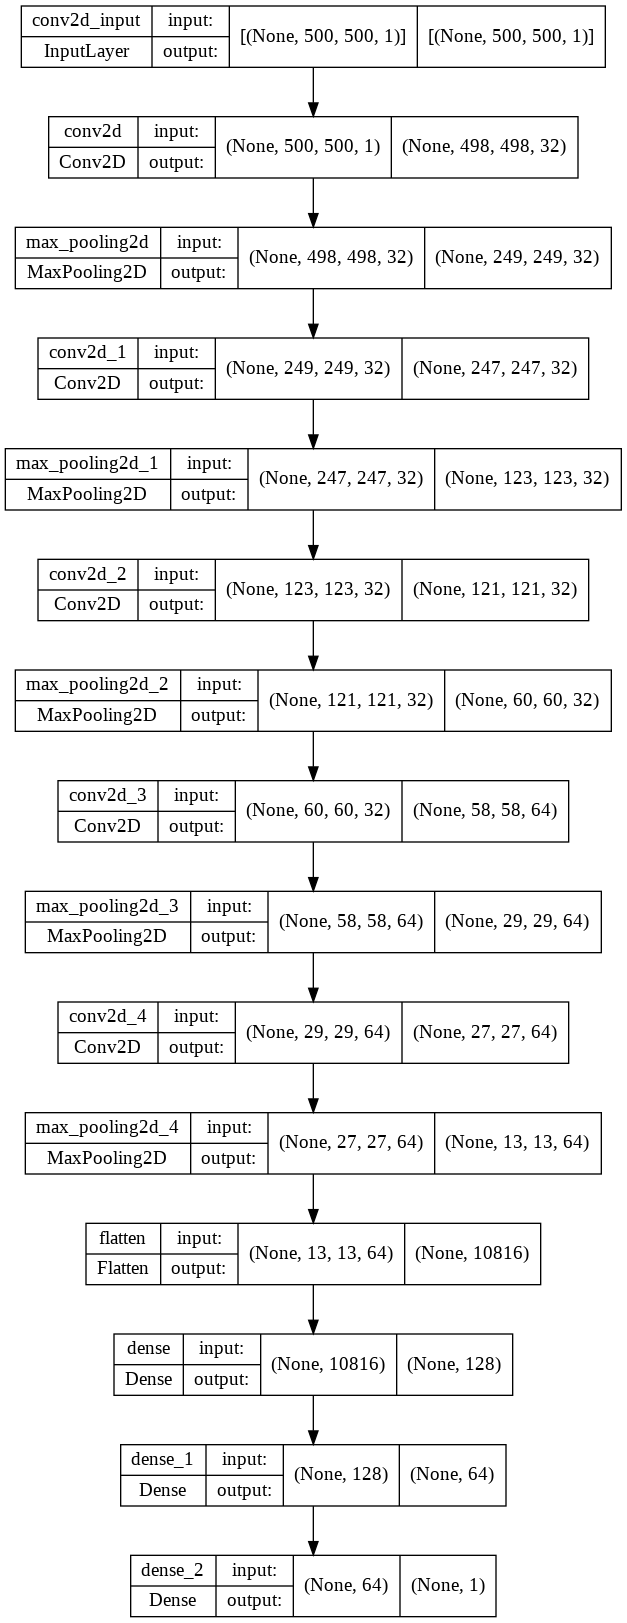

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

4. Fit the model and train

In [ ]:
early = EarlyStopping(monitor="val_loss",mode="min",patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight= (), callbacks=callbacks_list) #train the model

Epoch 1/25
262/262 [==============================] - 151s 533ms/step - loss: 0.3910 - accuracy: 0.8297 - val_loss: 0.3351 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 2/25
262/262 [==============================] - 139s 531ms/step - loss: 0.2343 - accuracy: 0.9079 - val_loss: 0.2760 - val_accuracy: 0.8731 - lr: 0.0010
Epoch 3/25
262/262 [==============================] - 138s 525ms/step - loss: 0.2154 - accuracy: 0.9108 - val_loss: 0.2070 - val_accuracy: 0.9135 - lr: 0.0010
Epoch 4/25
262/262 [==============================] - 137s 521ms/step - loss: 0.1799 - accuracy: 0.9325 - val_loss: 0.1617 - val_accuracy: 0.9269 - lr: 0.0010
Epoch 5/25
262/262 [==============================] - 137s 524ms/step - loss: 0.1866 - accuracy: 0.9292 - val_loss: 0.2585 - val_accuracy: 0.8904 - lr: 0.0010
Epoch 6/25
262/262 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9377
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
262/262 [========================

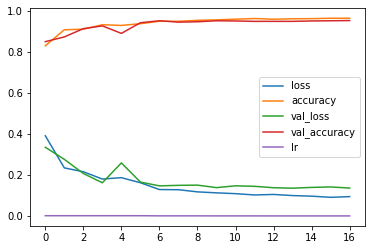

In [ ]:
pd.DataFrame(cnn.history.history).plot() #loss and accuracy plot

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 7s 165ms/step - loss: 0.3111 - accuracy: 0.8958
The testing accuracy is : 89.58333134651184 %


In [ ]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 7s 167ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

5. Prediction accuracy using confusion matrix

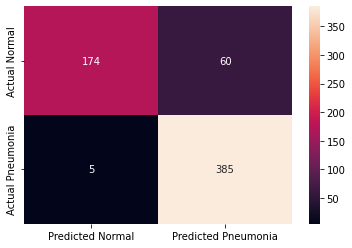

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix #confusion matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")


In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.97      0.74      0.84       234
   PNEUMONIA       0.87      0.99      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.88       624
weighted avg       0.91      0.90      0.89       624



In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
plt.imshow(np.squeeze(x[i]))
plt.axis('off')
plt.show()




In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 3.8 MB/s 
     |████████████████████████████████| 197 kB 50.9 MB/s 
     |████████████████████████████████| 1.2 MB 46.4 MB/s 
     |████████████████████████████████| 60 kB 7.0 MB/s 
Mounted at /content/gdrive


6. Using own data on the classifier

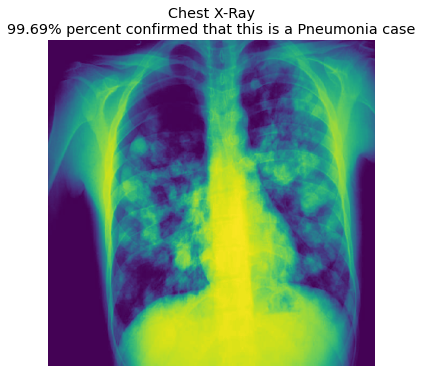

In [ ]:
# Testing different Chest X-Ray image
My_path = '/content/gdrive/MyDrive/chest_test/istockphoto-115203637-612x612.jpeg'
from tensorflow.keras.preprocessing import image
My_img = image.load_img(My_path, target_size=(500, 500),color_mode='grayscale')
# Preprocessing the image
pp_My_img = image.img_to_array(My_img)
pp_My_img = pp_My_img/255
pp_My_img = np.expand_dims(pp_My_img, axis=0)
#predict
My_preds= cnn.predict(pp_My_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if My_preds>= 0.5: 
    out = ('{:.2%} percent confirmed that this is a Pneumonia case'.format(My_preds[0][0]))
    
else: 
    out = ('{:.2%} percent confirmed that this is a Normal case'.format(1-My_preds[0][0]))
plt.title("Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_My_img))
plt.show()